# P03_03_LSTM_Multivariate


In [1]:
section_fig_main_title = 'P03_04_LSTM_Multivariate_'

In [2]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
import sys
# print(sys.executable)

In [4]:
# !/Users/amin/Desktop/proj/env/bin/python -m pip install matplotlib

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [6]:
%config InlineBackend.figure_format = 'retina'

In [7]:
import gif
from tqdm import tqdm

In [8]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

### Read data

In [10]:
csv_path = "../Data/jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

In [11]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [12]:
df.shape

(420551, 14)

Base on P02_03 EDA analysis I choose following columns for modeling.

The essential parameters to be considered for modeling are as follows.

```
'p (mbar)','Tpot (K)','Tdew (degC)','VPact (mbar)','sh (g/kg)','H2OC (mmol/mol)','rho (g/m**3)','wd (deg)'
```

In [13]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

import math
from sklearn.metrics import mean_squared_error

### Split the data

In [14]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [15]:
past

720

In [16]:
selected_features = ['p (mbar)','Tpot (K)','Tdew (degC)',
                     'VPact (mbar)','sh (g/kg)',
                     'H2OC (mmol/mol)','rho (g/m**3)','wd (deg)']

features = df[selected_features]
features.index = df.index

In [17]:
features.head()

,p (mbar),Tpot (K),Tdew (degC),VPact (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wd (deg)
Date Time,,,,,,,,
2009-01-01 00:10:00,996.52,265.40,-8.90,3.11,1.94,3.12,1307.75,152.3
2009-01-01 00:20:00,996.57,265.01,-9.28,3.02,1.89,3.03,1309.80,136.1
2009-01-01 00:30:00,996.53,264.91,-9.31,3.01,1.88,3.02,1310.24,171.6
2009-01-01 00:40:00,996.51,265.12,-9.07,3.07,1.92,3.08,1309.19,198.0
2009-01-01 00:50:00,996.51,265.15,-9.04,3.08,1.92,3.09,1309.00,214.3


In [18]:
features.shape

(420551, 8)

### Normalizing data

In [19]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7
0,0.955451,-2.060649,-1.953135,-1.497879,-1.500927,-1.503167,2.237658,-0.241025
1,0.961528,-2.105453,-2.007509,-1.519123,-1.519521,-1.524154,2.287838,-0.425626
2,0.956666,-2.116941,-2.011802,-1.521483,-1.523239,-1.526486,2.298608,-0.021100
3,0.954236,-2.092816,-1.977460,-1.507321,-1.508364,-1.512494,2.272906,0.279731
4,0.954236,-2.089370,-1.973168,-1.504960,-1.508364,-1.510162,2.268256,0.465471


In [20]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [26]:
train_data.head()

,0,1,2,3,4,5,6,7
0,0.955451,-2.060649,-1.953135,-1.497879,-1.500927,-1.503167,2.237658,-0.241025
1,0.961528,-2.105453,-2.007509,-1.519123,-1.519521,-1.524154,2.287838,-0.425626
2,0.956666,-2.116941,-2.011802,-1.521483,-1.523239,-1.526486,2.298608,-0.021100
3,0.954236,-2.092816,-1.977460,-1.507321,-1.508364,-1.512494,2.272906,0.279731
4,0.954236,-2.089370,-1.973168,-1.504960,-1.508364,-1.510162,2.268256,0.465471


In [27]:
start = past + future
end = start + train_split
print('start = ', start)
print('end = ', end)
print('train_split = ', train_split)
sequence_length = int(past / step)
print('sequence_length = ', sequence_length)

start =  792
end =  301485
train_split =  300693
sequence_length =  120


### Find out the temprature for next 72 hours

In [28]:
train_data.head()

,0,1,2,3,4,5,6,7
0,0.955451,-2.060649,-1.953135,-1.497879,-1.500927,-1.503167,2.237658,-0.241025
1,0.961528,-2.105453,-2.007509,-1.519123,-1.519521,-1.524154,2.287838,-0.425626
2,0.956666,-2.116941,-2.011802,-1.521483,-1.523239,-1.526486,2.298608,-0.021100
3,0.954236,-2.092816,-1.977460,-1.507321,-1.508364,-1.512494,2.272906,0.279731
4,0.954236,-2.089370,-1.973168,-1.504960,-1.508364,-1.510162,2.268256,0.465471


### Choose target column

In [30]:
features.iloc[start:end][[1]]

,1
792,-2.810826
793,-2.766022
794,-2.705135
795,-2.659182
796,-2.571872
...,...
301480,0.216303
301481,0.154267
301482,0.207112
301483,0.248469


In [31]:
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

In [32]:
# print('type = ', type(x_train))
# print("len of ", len(x_train))
# x_train

In [33]:
# print('type = ', type(y_train))
# print("size = ", y_train.size)
# # y_train.head()

```python
Example 1:

Consider indices `[0, 1, ... 99]`.
With `sequence_length=10,  sampling_rate=2, sequence_stride=3`,
`shuffle=False`, the dataset will yield batches of sequences
composed of the following indices:


First sequence:  [0  2  4  6  8 10 12 14 16 18]
Second sequence: [3  5  7  9 11 13 15 17 19 21]
Third sequence:  [6  8 10 12 14 16 18 20 22 24]


```

The stride defult value is 1. 
Note that the train and validation data set already divided considering the past value = 720, future = 72.

### Preprocessing data 

In [36]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(x_train,
                                                                  y_train,
                                                                  sequence_length=sequence_length,
                                                                  sampling_rate=step,
                                                                  batch_size=batch_size,
                                                                  )

2021-10-19 18:09:11.580457: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
type(dataset_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [38]:
x_end = len(val_data) - past - future
label_start = train_split + past + future

In [44]:
x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(x_val,
                                                                y_val,
                                                                sequence_length=sequence_length,
                                                                sampling_rate=step,
                                                                batch_size=batch_size,
                                                                )


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

2021-10-19 18:09:11.759209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Input shape: (256, 120, 7)
Target shape: (256, 1)


### Assemble keras model

In [46]:
inputs = keras.layers.Input(shape=(inputs.shape[1], 
                                   inputs.shape[2]))

lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="mse")

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [47]:
path_checkpoint = "LSTM_Multivariate.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=0, 
                                            patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
                                                    monitor="val_loss",
                                                    filepath=path_checkpoint,
                                                    verbose=1,
                                                    #save_weights_only=True,
                                                    save_best_only=True,
                                                )

history = model.fit(
                    dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[es_callback, modelckpt_callback],
                )

### Load the pre-trained model

In [48]:
from tensorflow.keras.models import *

In [49]:
path_1 = 'LSTM_Multivariate.h5'
model = keras.models.load_model(path_1)

In [50]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [58]:
def show_plot(plot_data, delta, title):
    
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
            
            
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    
    return

In [73]:
real_values = []
predited_values = []

for x, y in dataset_val.take(463):
    
    real_values.append(y[0].numpy())
    predited_values.append(model.predict(x)[0])
    
#     print(model.predict(x)[0])
#     print(y[0].numpy())
    
#     show_plot([x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
#               12,
#               "Single Step Prediction",
#               )

In [75]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(real_values, predited_values)
coefficient_of_dermination

0.8404073408337346

In [76]:
rs2 = round(coefficient_of_dermination,2)

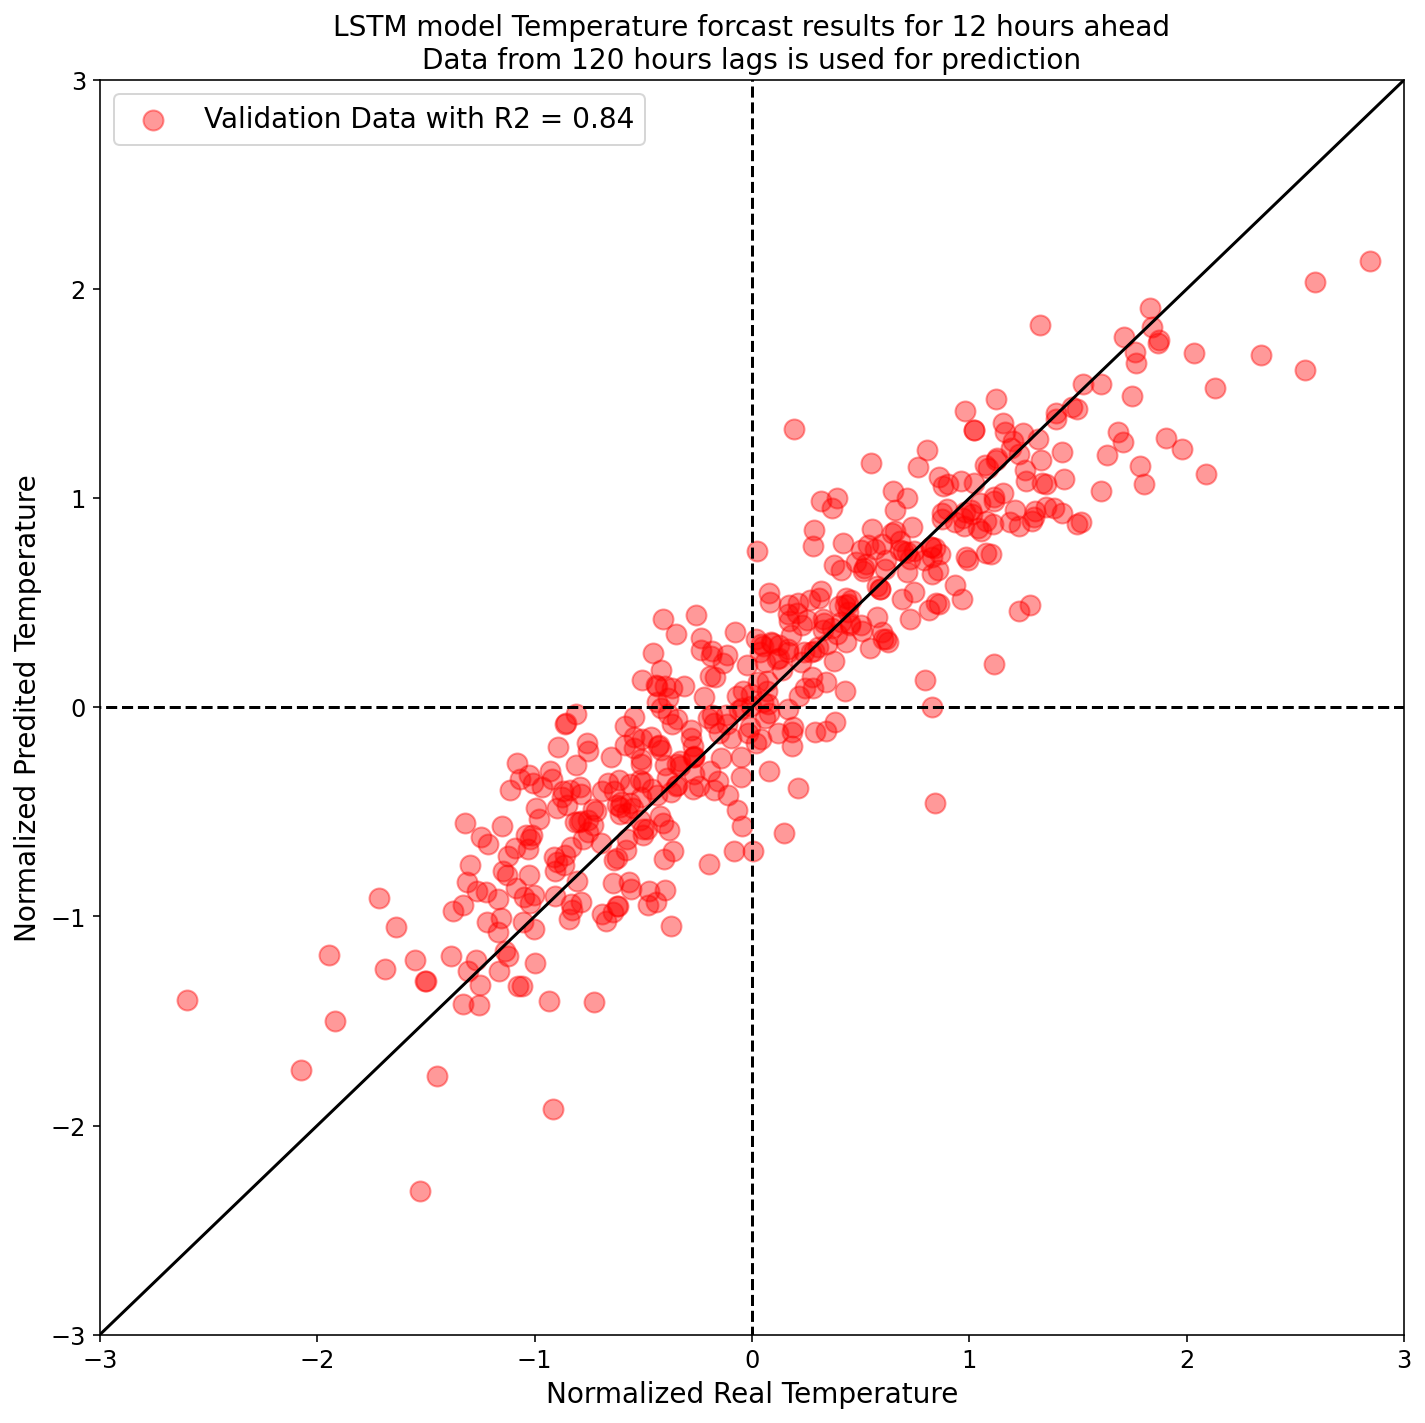

In [77]:
plt.figure(figsize=(10,10))

plt.scatter(real_values, predited_values, color='r', 
            alpha=0.4, label=f'Validation Data with R2 = {rs2}',s=100)
plt.xlabel("Normalized Real Temperature", fontsize=14)
plt.ylabel("Normalized Predited Temperature", fontsize=14)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.axline([0, 0], [1, 1], color ='k')
plt.hlines(0, -4, 4, linestyles="--", color ='k')
plt.vlines(0, -4, 4, linestyles="--", color ='k')

plt.xlim(-3,3), plt.ylim(-3,3)

plt.title("LSTM model Temperature forcast results for 12 \
hours ahead\nData from 120 hours lags is used for prediction", fontsize=14)

plt.tight_layout()
plt.legend(fontsize=14)

plt.savefig("../Figures/" + section_fig_main_title + "LSTM12HoursAhead.png")

clearly, high variance is observed. However the model follow the data trend with R-sq~0.85 and the model bias is low and good.

In [79]:
residuals = np.array(real_values) - np.array(predited_values)

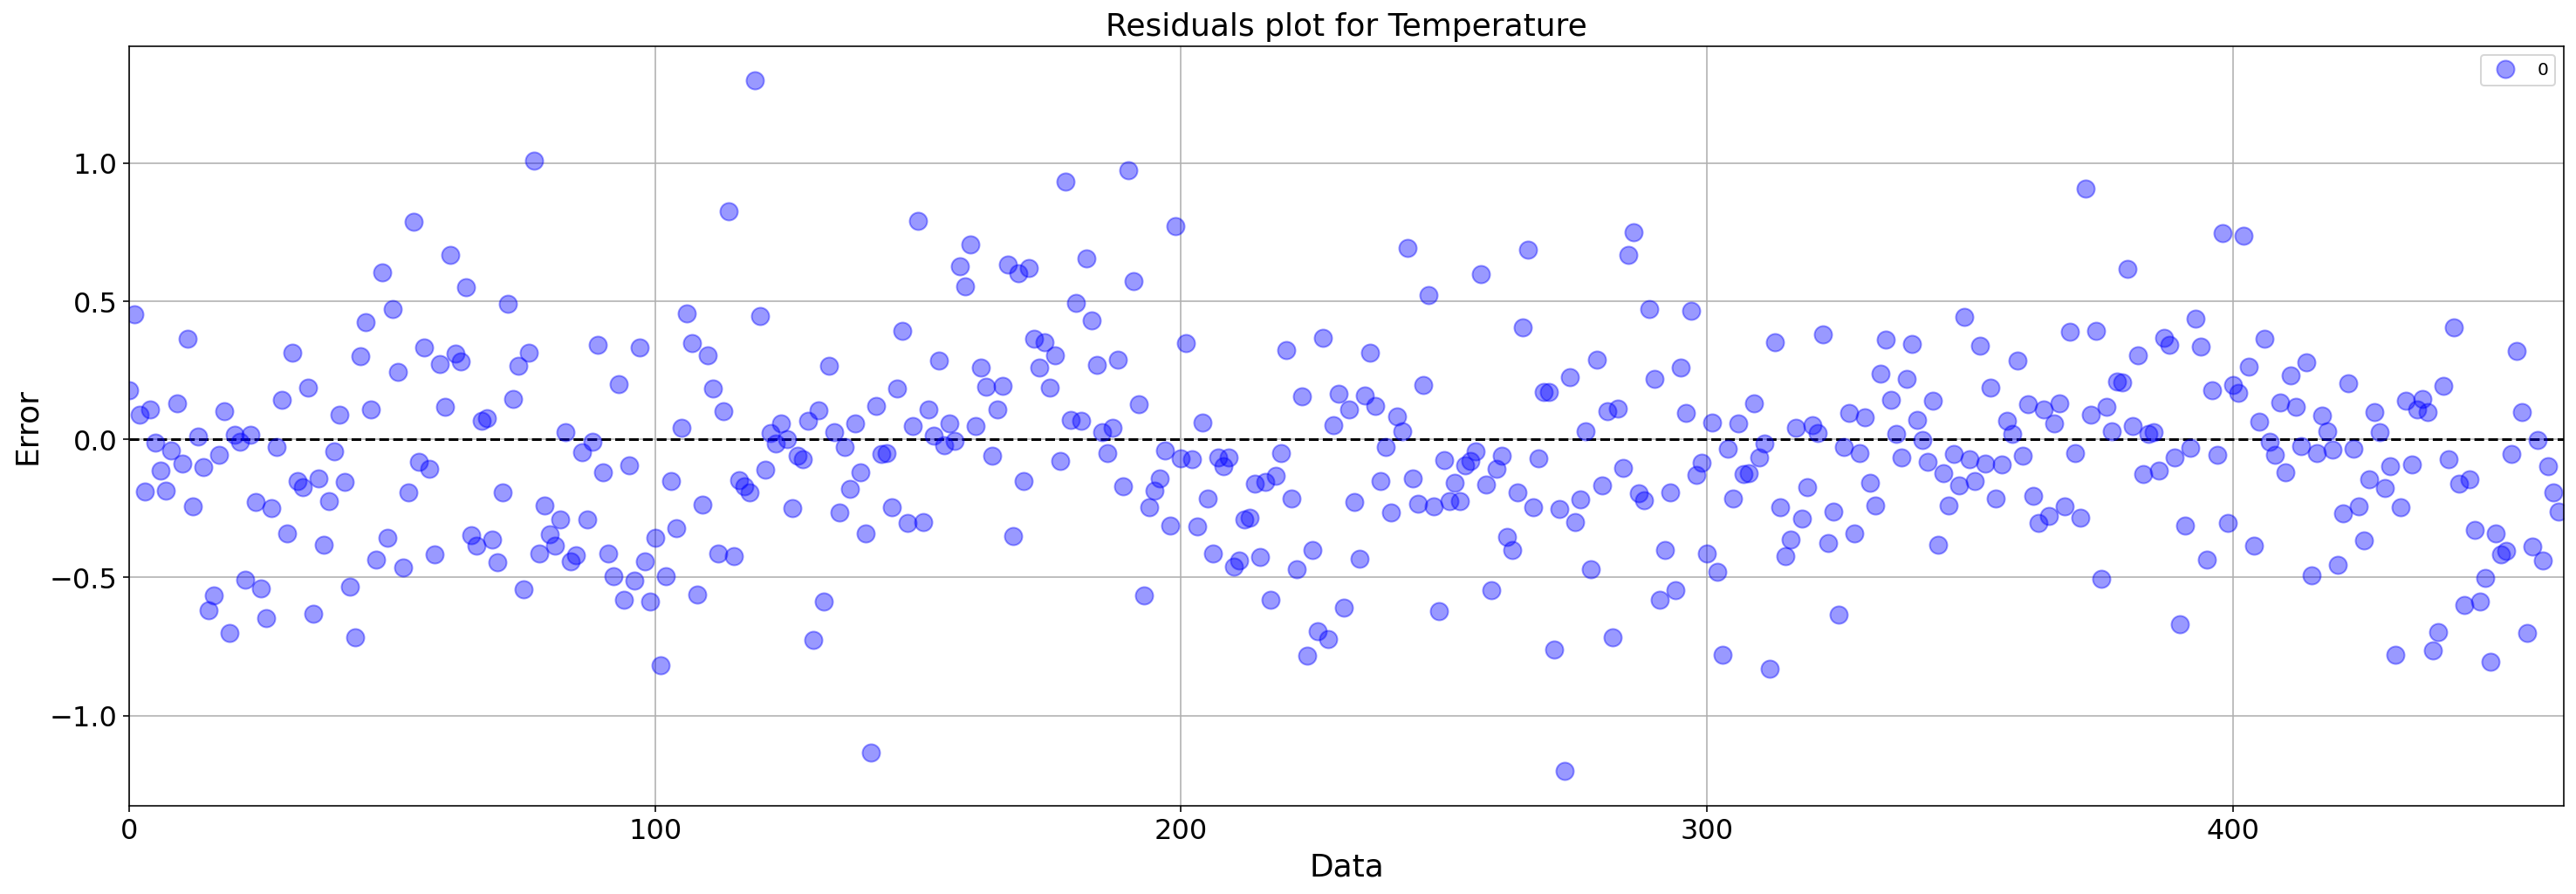

In [106]:
residuals = pd.DataFrame(residuals)
residuals.plot(kind='line', style='.',
                    figsize=(25,8), 
                    grid=True, 
                    ylabel="Temperature c",
                    c='b', markersize=20, alpha=0.4)

plt.hlines(0, 0, 463, linestyles="--", color ='k')
plt.xlim(0,463)
plt.xlabel("Data", fontsize=18)
plt.ylabel("Error", fontsize=18)
plt.title('Residuals plot for Temperature', fontsize=18)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.savefig("../Figures/" + section_fig_main_title + "LSTM12HoursAhead_residu.png")

In [92]:
print("residuals.mean() ",residuals.mean()[0])
print( "residuals.std() ", residuals.std()[0])

residuals.mean()  -0.04665188562486857
residuals.std()  0.35592571988349403


Erorr (residuals) variance is constant.

Error does not have any trend versus data and it scatterd equally around zero (mean).